In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-note-authentication-uci-data/BankNote_Authentication.csv


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb

import sklearn.metrics as metric
from sklearn.model_selection import StratifiedKFold

In [31]:
# Load the dataset
df = pd.read_csv('/kaggle/input/bank-note-authentication-uci-data/BankNote_Authentication.csv')
df

,variance,skewness,curtosis,entropy,class
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


In [32]:
# Understanding of data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   curtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   class     1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


In [33]:
df.describe()

,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


In [34]:
# To check for the missing values
df.isna().sum()

variance    0
skewness    0
curtosis    0
entropy     0
class       0
dtype: int64

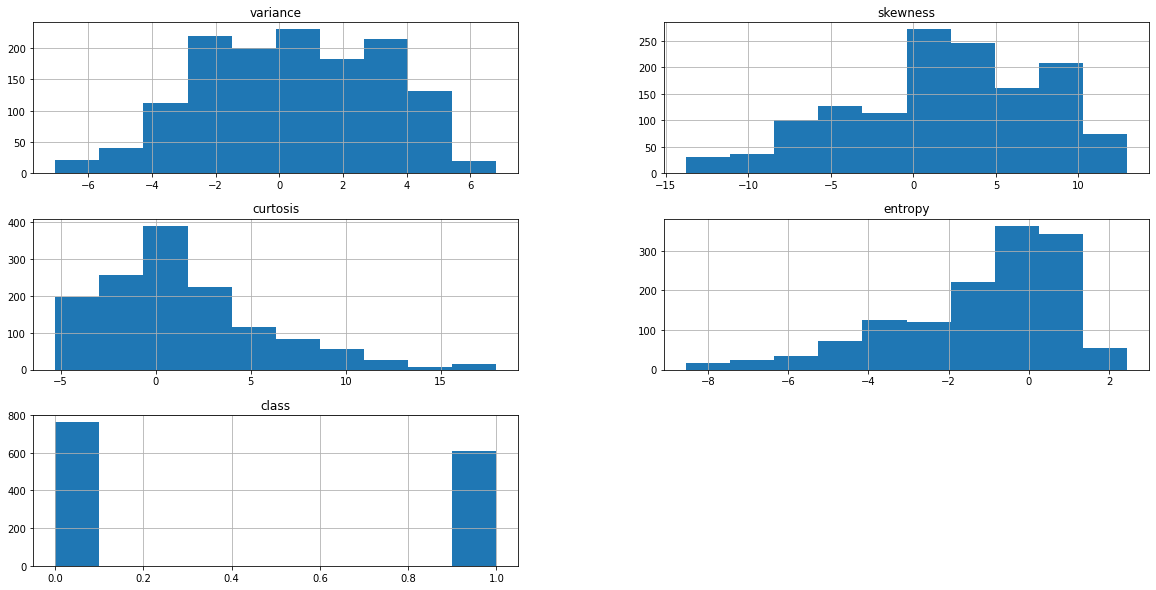

In [35]:
# Check for distribution of data
ax = df.hist(figsize=(20,10))
plt.show()

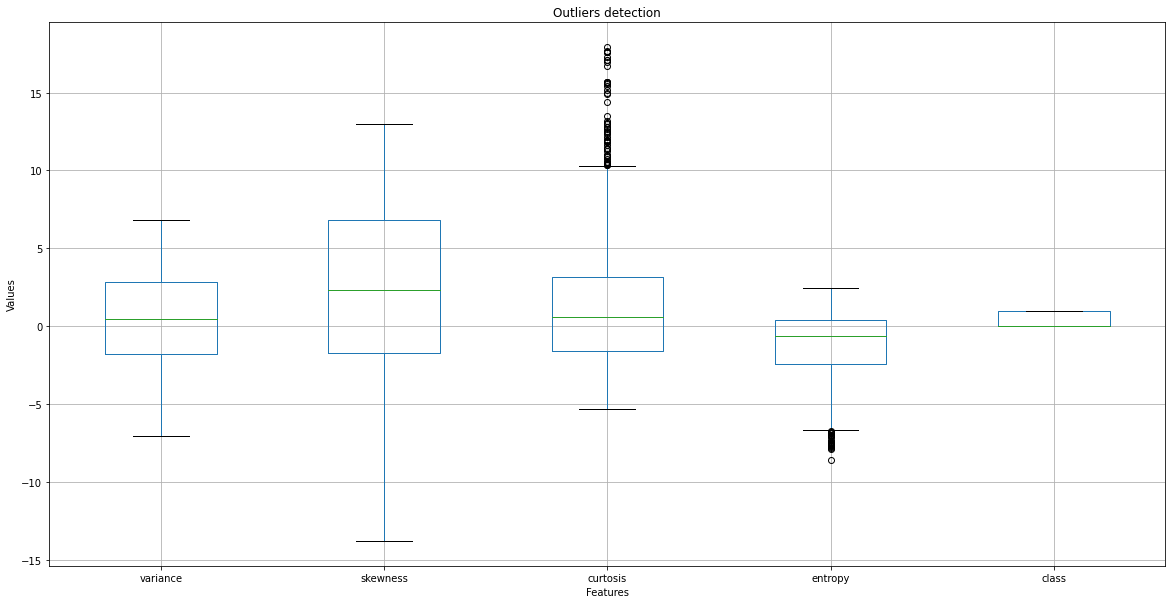

In [36]:
# Check for outliers
ax = df.boxplot(figsize=(20,10))
ax.set_xlabel('Features')
ax.set_ylabel('Values')
ax.set_title('Outliers detection')
plt.show()

- variance and skewness can be normalized using StandardScaler however curtosis and entropy has outliers and skewness so can be treated with PowerTransformer

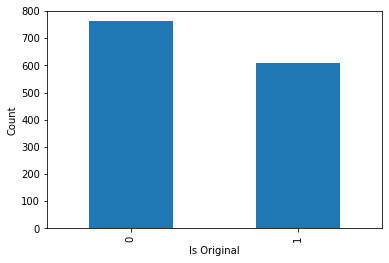

In [37]:
# To check if data is balanced or imbalanced
ax = df['class'].value_counts().plot(kind='bar')
ax.set_xlabel('Is Original')
ax.set_ylabel('Count')
plt.show()

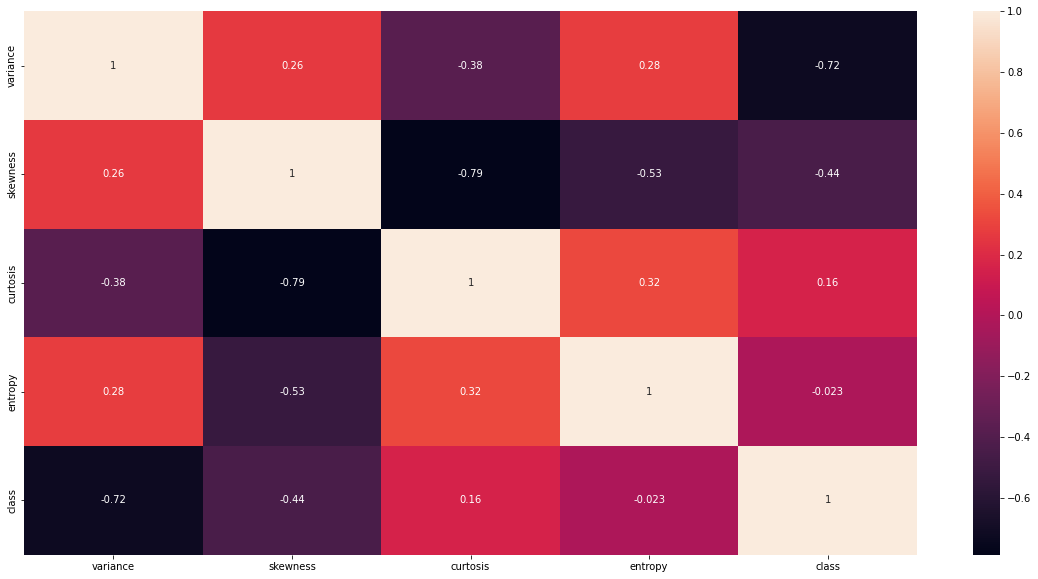

In [38]:
# Bivariate analysis
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(), annot=True)
plt.show()

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer

In [40]:
X = df.drop('class', axis=1)
y = df['class']

In [41]:
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2)

In [42]:
to_std = ['variance','skewness']
to_log = ['curtosis','entropy']

In [43]:
# To normalise the data with StandardScaler
std = StandardScaler()
std_X_tr = pd.DataFrame(std.fit_transform(X_tr[to_std]))
std_X_val = pd.DataFrame(std.transform(X_val[to_std]))

std_X_tr.index = X_tr.index
std_X_val.index = X_val.index

X_tr[to_std] = std_X_tr
X_val[to_std] = std_X_val

In [44]:
# To normalise the data with PowerTrasformer
log = PowerTransformer()
log_X_tr = pd.DataFrame(log.fit_transform(X_tr[to_log]))
log_X_val = pd.DataFrame(log.transform(X_val[to_log]))

log_X_tr.index = X_tr.index
log_X_val.index = X_val.index

X_tr[to_log] = log_X_tr
X_val[to_log] = log_X_val

In [45]:
estimators = {
    'LogisticRegression': LogisticRegression(),
    'RandomForestClassifier': RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=5),
    'SVM': SVC(),
    'XGB': xgb.XGBClassifier()
}

In [46]:
def train_model(estimator, X_train, X_test, y_train, y_test):
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    print(f'The accuracy score is: {metric.accuracy_score(y_test, y_pred):.4f}')
    print(f'The report is: {metric.classification_report(y_test, y_pred)}')
    print('#'*100)

In [47]:
def estimator_dict(X_train, X_test, y_train, y_test):
    for name, estimator in estimators.items():
        print(name)
        train_model(estimator, X_train, X_test, y_train, y_test)

In [48]:
estimator_dict(X_tr, X_val, y_tr, y_val)

LogisticRegression
The accuracy score is: 0.9964
The report is:               precision    recall  f1-score   support

           0       1.00      0.99      1.00       153
           1       0.99      1.00      1.00       122

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275

####################################################################################################
RandomForestClassifier
The accuracy score is: 0.9927
The report is:               precision    recall  f1-score   support

           0       1.00      0.99      0.99       153
           1       0.98      1.00      0.99       122

    accuracy                           0.99       275
   macro avg       0.99      0.99      0.99       275
weighted avg       0.99      0.99      0.99       275

####################################################################################################
GradientBoos

- All estimators are giving almost same result.

In [49]:
X_cross = X.copy()
y_cross = y.copy()

In [50]:
std_cross = StandardScaler()
X_cross_std = pd.DataFrame(std_cross.fit_transform(X_cross[to_std]))

X_cross_std.index = X_cross.index
X_cross[to_std] = X_cross_std

In [51]:
log_cross = PowerTransformer()
X_cross_log = pd.DataFrame(log_cross.fit_transform(X_cross[to_log]))

X_cross_log.index = X_cross.index
X_cross[to_log] = X_cross_log

In [52]:
# Training model with cross validation
xgb_cls = xgb.XGBClassifier()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=102)

acc = []
roc = []
for train_idx, val_idx in skf.split(X_cross, y_cross):
    X_train_fold, X_val_fold = X_cross.loc[train_idx], X_cross.loc[val_idx]
    y_train_fold, y_val_fold = y_cross.loc[train_idx], y_cross.loc[val_idx] 
    xgb_cls.fit(X_train_fold, y_train_fold)
    y_pred = xgb_cls.predict(X_val_fold)
    y_prob = xgb_cls.predict_proba(X_val_fold)
    acc_score = metric.accuracy_score(y_val_fold, y_pred)
    roc_score = metric.roc_auc_score(y_val_fold, y_prob[:,1])
    acc.append(acc_score)
    roc.append(roc_score)
print(f'The Accuracy is {acc}')
print(f'The ROC is {roc}')
print(f'Mean Accuracy is {np.mean(acc):.4f}')
print(f'Mean ROC is: {np.mean(roc):.4f}')

The Accuracy is [0.9927272727272727, 0.9818181818181818, 1.0, 0.9890510948905109, 1.0]
The ROC is [1.0, 0.9993571198971392, 0.9999999999999999, 0.9994068162208801, 1.0]
Mean Accuracy is 0.9927
Mean ROC is: 0.9998
